# FSRS4Anki Optimizer Post-Lapse Stability Offset

[![open in colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/open-spaced-repetition/fsrs4anki/blob/main/archive/candidate/post-lapse_stability_offset.ipynb)

In [1]:
# Here are some settings that you need to replace before running this optimizer.

filename = "../collection-2022-09-18@13-21-58.colpkg"
# If you upload deck file, replace it with your deck filename. E.g., ALL__Learning.apkg
# If you upload collection file, replace it with your colpgk filename. E.g., collection-2022-09-18@13-21-58.colpkg

# Replace it with your timezone. I'm in China, so I use Asia/Shanghai.
# You can find your timezone here: https://gist.github.com/heyalexej/8bf688fd67d7199be4a1682b3eec7568
timezone = 'Asia/Shanghai'

# Replace it with your Anki's setting in Preferences -> Scheduling.
next_day_starts_at = 4

# Replace it if you don't want the optimizer to use the review logs before a specific date.
revlog_start_date = "2006-10-05"

# Set it to True if you don't want the optimizer to use the review logs from suspended cards.
filter_out_suspended_cards = False

In [2]:
import zipfile
import sqlite3
import time
import pandas as pd
import numpy as np
import os
import math
from typing import List, Optional
from datetime import timedelta, datetime
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import torch
from torch import nn
from torch import Tensor
from torch.utils.data import Dataset, DataLoader, Sampler
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.metrics import mean_squared_error, r2_score
from itertools import accumulate
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
tqdm.pandas()

In [3]:
"""Step 1"""
# Extract the collection file or deck file to get the .anki21 database.
with zipfile.ZipFile(f'{filename}', 'r') as zip_ref:
    zip_ref.extractall('./')
    print("Deck file extracted successfully!")

"""Step 2"""
if os.path.isfile("collection.anki21b"):
    os.remove("collection.anki21b")
    raise Exception(
        "Please export the file with `support older Anki versions` if you use the latest version of Anki.")
elif os.path.isfile("collection.anki21"):
    con = sqlite3.connect("collection.anki21")
elif os.path.isfile("collection.anki2"):
    con = sqlite3.connect("collection.anki2")
else:
    raise Exception("Collection not exist!")
cur = con.cursor()
res = cur.execute(f"""
SELECT *
FROM revlog
WHERE cid IN (
    SELECT id
    FROM cards
    {"WHERE queue != -1" if filter_out_suspended_cards else ""}
)
"""
)
revlog = res.fetchall()
if len(revlog) == 0:
    raise Exception("No review log found!")
df = pd.DataFrame(revlog)
df.columns = ['id', 'cid', 'usn', 'r', 'ivl', 'last_lvl', 'factor', 'time', 'type']
df = df[(df['cid'] <= time.time() * 1000) &
        (df['id'] <= time.time() * 1000)].copy()

df_set_due_date = df[(df['type'] == 4) & (df['ivl'] > 0)]
df.drop(df_set_due_date.index, inplace=True)

df['create_date'] = pd.to_datetime(df['cid'] // 1000, unit='s')
df['create_date'] = df['create_date'].dt.tz_localize('UTC').dt.tz_convert(timezone)
df['review_date'] = pd.to_datetime(df['id'] // 1000, unit='s')
df['review_date'] = df['review_date'].dt.tz_localize('UTC').dt.tz_convert(timezone)
df.drop(df[df['review_date'].dt.year < 2006].index, inplace=True)
df.sort_values(by=['cid', 'id'], inplace=True, ignore_index=True)

df['is_learn_start'] = (df['type'] == 0) & (df['type'].shift() != 0)
df['sequence_group'] = df['is_learn_start'].cumsum()
last_learn_start = df[df['is_learn_start']].groupby('cid')['sequence_group'].last()
df['last_learn_start'] = df['cid'].map(last_learn_start).fillna(0).astype(int)
df['mask'] = df['last_learn_start'] <= df['sequence_group']
df = df[df['mask'] == True].copy()
df.drop(columns=['is_learn_start', 'sequence_group', 'last_learn_start', 'mask'], inplace=True)
df = df[(df['type'] != 4)].copy()

type_sequence = np.array(df['type'])
time_sequence = np.array(df['time'])
df.to_csv("revlog.csv", index=False)
print("revlog.csv saved.")

df = df[(df['type'] != 3) | (df['factor'] != 0)].copy()
df['real_days'] = df['review_date'] - timedelta(hours=int(next_day_starts_at))
df['real_days'] = pd.DatetimeIndex(df['real_days'].dt.floor('D', ambiguous='infer', nonexistent='shift_forward')).to_julian_date()
df.drop_duplicates(['cid', 'real_days'], keep='first', inplace=True)
df['delta_t'] = df.real_days.diff()
df.dropna(inplace=True)
df['i'] = df.groupby('cid').cumcount() + 1
df.loc[df['i'] == 1, 'delta_t'] = 0
df = df.groupby('cid').filter(lambda group: group['type'].iloc[0] == 0)
df['prev_type'] = df.groupby('cid')['type'].shift(1).fillna(0).astype(int)
df['helper'] = ((df['type'] == 0) & ((df['prev_type'] == 1) | (df['prev_type'] == 2)) & (df['i'] > 1)).astype(int)
df['helper'] = df.groupby('cid')['helper'].cumsum()
df = df[df['helper'] == 0]
del df['prev_type']
del df['helper']

def cum_concat(x):
    return list(accumulate(x))

t_history = df.groupby('cid', group_keys=False)['delta_t'].apply(lambda x: cum_concat([[int(i)] for i in x]))
df['t_history']=[','.join(map(str, item[:-1])) for sublist in t_history for item in sublist]
r_history = df.groupby('cid', group_keys=False)['r'].apply(lambda x: cum_concat([[i] for i in x]))
df['r_history']=[','.join(map(str, item[:-1])) for sublist in r_history for item in sublist]
df = df.groupby('cid').filter(lambda group: group['id'].min() > time.mktime(datetime.strptime(revlog_start_date, "%Y-%m-%d").timetuple()) * 1000)
df['y'] = df['r'].map(lambda x: {1: 0, 2: 1, 3: 1, 4: 1}[x])
df.to_csv('revlog_history.tsv', sep="\t", index=False)
print("Trainset saved.")

df['retention'] = df.groupby(by=['r_history', 'delta_t'], group_keys=False)['y'].transform('mean')
df['total_cnt'] = df.groupby(by=['r_history', 'delta_t'], group_keys=False)['id'].transform('count')
print("Retention calculated.")

df = df.drop(columns=['id', 'cid', 'usn', 'ivl', 'last_lvl', 'factor', 'time', 'type', 'create_date', 'review_date', 'real_days', 'r', 't_history', 'y'])
df.drop_duplicates(inplace=True)
df['retention'] = df['retention'].map(lambda x: max(min(0.99, x), 0.01))

def cal_stability(group: pd.DataFrame) -> pd.DataFrame:
    group_cnt = sum(group['total_cnt'])
    if group_cnt < 10:
        return pd.DataFrame()
    group['group_cnt'] = group_cnt
    if group['i'].values[0] > 1:
        r_ivl_cnt = sum(group['delta_t'] * group['retention'].map(np.log) * pow(group['total_cnt'], 2))
        ivl_ivl_cnt = sum(group['delta_t'].map(lambda x: x ** 2) * pow(group['total_cnt'], 2))
        group['stability'] = round(np.log(0.9) / (r_ivl_cnt / ivl_ivl_cnt), 1)
    else:
        group['stability'] = 0.0
    group['avg_retention'] = round(sum(group['retention'] * pow(group['total_cnt'], 2)) / sum(pow(group['total_cnt'], 2)), 3)
    group['avg_interval'] = round(sum(group['delta_t'] * pow(group['total_cnt'], 2)) / sum(pow(group['total_cnt'], 2)), 1)
    del group['total_cnt']
    del group['retention']
    del group['delta_t']
    return group

df = df.groupby(by=['r_history'], group_keys=False).progress_apply(cal_stability)
print("Stability calculated.")
df.reset_index(drop = True, inplace = True)
df.drop_duplicates(inplace=True)
df.sort_values(by=['r_history'], inplace=True, ignore_index=True)

if df.shape[0] > 0:
    for idx in tqdm(df.index, desc="analysis"):
        item = df.loc[idx]
        index = df[(df['i'] == item['i'] + 1) & (df['r_history'].str.startswith(item['r_history']))].index
        df.loc[index, 'last_stability'] = item['stability']
    df['factor'] = round(df['stability'] / df['last_stability'], 2)
    df = df[(df['i'] >= 2) & (df['group_cnt'] >= 100)].copy()
    df['last_recall'] = df['r_history'].map(lambda x: x[-1])
    df = df[df.groupby(['i', 'r_history'], group_keys=False)['group_cnt'].transform(max) == df['group_cnt']]
    df.to_csv('./stability_for_analysis.tsv', sep='\t', index=None)
    print("Analysis saved!")
    caption = "1:again, 2:hard, 3:good, 4:easy\n"
    analysis = df[df['r_history'].str.contains(r'^[1-4][^124]*$', regex=True)][['r_history', 'avg_interval', 'avg_retention', 'stability', 'factor', 'group_cnt']].to_string(index=False)
    print(caption + analysis)

Deck file extracted successfully!
revlog.csv saved.
Trainset saved.
Retention calculated.


  0%|          | 0/26286 [00:00<?, ?it/s]

Stability calculated.


analysis:   0%|          | 0/489 [00:00<?, ?it/s]

Analysis saved!
1:again, 2:hard, 3:good, 4:easy
      r_history  avg_interval  avg_retention  stability  factor  group_cnt
              1           1.1          0.892        1.0     inf       2063
            1,3           3.1          0.920        4.0    4.00       1600
          1,3,3           7.1          0.910        7.9    1.98       1320
        1,3,3,3          16.6          0.862       10.8    1.37        986
      1,3,3,3,3          36.5          0.840       22.3    2.06        659
    1,3,3,3,3,3          77.0          0.861       36.4    1.63        358
  1,3,3,3,3,3,3         117.9          0.906       38.5    1.06        177
              2           1.0          0.902        1.1     inf        240
            2,3           3.5          0.946        8.2    7.45        201
          2,3,3          11.4          0.890        7.6    0.93        162
              3           1.1          0.977        5.0     inf       4669
            3,3           3.3          0.967       1

In [4]:
init_w = [1, 1, 5, -0.5, -0.5, 0.2, 1.4, -0.2, 0.8, 2, -0.2, 0.2, 1]

class FSRS(nn.Module):
    def __init__(self, w: List[float]):
        super(FSRS, self).__init__()
        self.w = nn.Parameter(torch.tensor(w, dtype=torch.float32))

    def stability_after_success(self, state: Tensor, new_d: Tensor, r: Tensor) -> Tensor:
        new_s = state[:,0] * (1 + torch.exp(self.w[6]) *
                        (11 - new_d) *
                        torch.pow(state[:,0], self.w[7]) *
                        (torch.exp((1 - r) * self.w[8]) - 1))
        return new_s

    def stability_after_failure(self, state: Tensor, new_d: Tensor, r: Tensor) -> Tensor:
        new_s = self.w[9] * torch.pow(new_d, self.w[10]) * (torch.pow(
            state[:,0] + 1, self.w[11]) - 1) * torch.exp((1 - r) * self.w[12])
        return new_s

    def step(self, X: Tensor, state: Tensor) -> Tensor:
        '''
        :param X: shape[batch_size, 2], X[:,0] is elapsed time, X[:,1] is rating
        :param state: shape[batch_size, 2], state[:,0] is stability, state[:,1] is difficulty
        :return state:
        '''
        if torch.equal(state, torch.zeros_like(state)):
            # first learn, init memory states
            new_s = self.w[0] + self.w[1] * (X[:,1] - 1)
            new_d = self.w[2] + self.w[3] * (X[:,1] - 3)
            new_d = new_d.clamp(1, 10)
        else:
            r = torch.exp(np.log(0.9) * X[:,0] / state[:,0])
            new_d = state[:,1] + self.w[4] * (X[:,1] - 3)
            new_d = self.mean_reversion(self.w[2], new_d)
            new_d = new_d.clamp(1, 10)
            condition = X[:,1] > 1
            new_s = torch.where(condition, self.stability_after_success(state, new_d, r), self.stability_after_failure(state, new_d, r))
        new_s = new_s.clamp(0.1, 36500)
        return torch.stack([new_s, new_d], dim=1)

    def forward(self, inputs: Tensor, state: Optional[Tensor]=None) -> Tensor:
        '''
        :param inputs: shape[seq_len, batch_size, 2]
        '''
        if state is None:
            state = torch.zeros((inputs.shape[1], 2))
        outputs = []
        for X in inputs:
            state = self.step(X, state)
            outputs.append(state)
        return torch.stack(outputs), state

    def mean_reversion(self, init: Tensor, current: Tensor) -> Tensor:
        return self.w[5] * init + (1-self.w[5]) * current

class WeightClipper:
    def __init__(self, frequency: int=1):
        self.frequency = frequency

    def __call__(self, module):
        if hasattr(module, 'w'):
            w = module.w.data
            w[0] = w[0].clamp(0.1, 10)
            w[1] = w[1].clamp(0.1, 5)
            w[2] = w[2].clamp(1, 10)
            w[3] = w[3].clamp(-5, -0.1)
            w[4] = w[4].clamp(-5, -0.1)
            w[5] = w[5].clamp(0.05, 0.5)
            w[6] = w[6].clamp(0, 2)
            w[7] = w[7].clamp(-0.8, -0.15)
            w[8] = w[8].clamp(0.01, 1.5)
            w[9] = w[9].clamp(0.5, 5)
            w[10] = w[10].clamp(-2, -0.01)
            w[11] = w[11].clamp(0.01, 0.9)
            w[12] = w[12].clamp(0.01, 2)
            module.w.data = w

def lineToTensor(line: str) -> Tensor:
    ivl = line[0].split(',')
    response = line[1].split(',')
    tensor = torch.zeros(len(response), 2)
    for li, response in enumerate(response):
        tensor[li][0] = int(ivl[li])
        tensor[li][1] = int(response)
    return tensor

class RevlogDataset(Dataset):
    def __init__(self, dataframe: pd.DataFrame):
        if dataframe.empty:
            raise ValueError('Training data is inadequate.')
        padded = pad_sequence(dataframe['tensor'].to_list(), batch_first=True, padding_value=0)
        self.x_train = padded.int()
        self.t_train = torch.tensor(dataframe['delta_t'].values, dtype=torch.int)
        self.y_train = torch.tensor(dataframe['y'].values, dtype=torch.float)
        self.seq_len = torch.tensor(dataframe['tensor'].map(len).values, dtype=torch.long)

    def __getitem__(self, idx):
        return self.x_train[idx], self.t_train[idx], self.y_train[idx], self.seq_len[idx]

    def __len__(self):
        return len(self.y_train)

class RevlogSampler(Sampler[List[int]]):
    def __init__(self, data_source: RevlogDataset, batch_size: int):
        self.data_source = data_source
        self.batch_size = batch_size
        lengths = np.array(data_source.seq_len)
        indices = np.argsort(lengths)
        full_batches, remainder = divmod(indices.size, self.batch_size)
        if full_batches > 0:
            if remainder == 0:
                self.batch_indices = np.split(indices, full_batches)
            else:
                self.batch_indices = np.split(indices[:-remainder], full_batches)
        else:
            self.batch_indices = []
        if remainder > 0:
            self.batch_indices.append(indices[-remainder:])
        self.batch_nums = len(self.batch_indices)
        # seed = int(torch.empty((), dtype=torch.int64).random_().item())
        seed = 2023
        self.generator = torch.Generator()
        self.generator.manual_seed(seed)

    def __iter__(self):
        yield from (self.batch_indices[idx] for idx in torch.randperm(self.batch_nums, generator=self.generator).tolist())

    def __len__(self):
        return len(self.data_source)


def collate_fn(batch):
    sequences, delta_ts, labels, seq_lens = zip(*batch)
    sequences_packed = pack_padded_sequence(torch.stack(sequences, dim=1), lengths=torch.stack(seq_lens), batch_first=False, enforce_sorted=False)
    sequences_padded, length = pad_packed_sequence(sequences_packed, batch_first=False)
    sequences_padded = torch.as_tensor(sequences_padded)
    seq_lens = torch.as_tensor(length)
    delta_ts = torch.as_tensor(delta_ts)
    labels = torch.as_tensor(labels)
    return sequences_padded, delta_ts, labels, seq_lens

class Trainer:
    def __init__(self, train_set: pd.DataFrame, test_set: pd.DataFrame, init_w: List[float], n_epoch: int=1, lr: float=1e-2, batch_size: int=256) -> None:
        self.model = FSRS(init_w)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)
        self.clipper = WeightClipper()
        self.batch_size = batch_size
        self.build_dataset(train_set, test_set)
        self.n_epoch = n_epoch
        self.batch_nums = self.next_train_data_loader.batch_sampler.batch_nums
        self.scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(self.optimizer, T_max=self.batch_nums * n_epoch)
        self.avg_train_losses = []
        self.avg_eval_losses = []
        self.loss_fn = nn.BCELoss(reduction='sum')

    def build_dataset(self, train_set: pd.DataFrame, test_set: pd.DataFrame):
        pre_train_set = train_set[train_set['i'] == 2]
        self.pre_train_set = RevlogDataset(pre_train_set)
        sampler = RevlogSampler(self.pre_train_set, batch_size=self.batch_size)
        self.pre_train_data_loader = DataLoader(self.pre_train_set, batch_sampler=sampler, collate_fn=collate_fn)

        next_train_set = train_set[train_set['i'] > 2]
        self.next_train_set = RevlogDataset(next_train_set)
        sampler = RevlogSampler(self.next_train_set, batch_size=self.batch_size)
        self.next_train_data_loader = DataLoader(self.next_train_set, batch_sampler=sampler, collate_fn=collate_fn)

        self.train_set = RevlogDataset(train_set)
        sampler = RevlogSampler(self.train_set, batch_size=self.batch_size)
        self.train_data_loader = DataLoader(self.train_set, batch_sampler=sampler, collate_fn=collate_fn)

        self.test_set = RevlogDataset(test_set)
        sampler = RevlogSampler(self.test_set, batch_size=self.batch_size)
        self.test_data_loader = DataLoader(self.test_set, batch_sampler=sampler, collate_fn=collate_fn)
        print("dataset built")

    def train(self, verbose: bool=True):
        # pretrain
        best_loss = np.inf
        weighted_loss, w = self.eval()
        if weighted_loss < best_loss:
            best_loss = weighted_loss
            best_w = w

        pbar = tqdm(desc="pre-train", colour="red", total=len(self.pre_train_data_loader) * self.n_epoch)
        for k in range(self.n_epoch):
            for i, batch in enumerate(self.pre_train_data_loader):
                self.model.train()
                self.optimizer.zero_grad()
                sequences, delta_ts, labels, seq_lens = batch
                real_batch_size = seq_lens.shape[0]
                outputs, _ = self.model(sequences)
                stabilities = outputs[seq_lens-1, torch.arange(real_batch_size), 0]
                retentions = torch.exp(np.log(0.9) * delta_ts / stabilities)
                loss = self.loss_fn(retentions, labels)
                loss.backward()
                self.optimizer.step()
                self.model.apply(self.clipper)
                pbar.update(n=real_batch_size)

        pbar.close()
        for name, param in self.model.named_parameters():
            tqdm.write(f"{name}: {list(map(lambda x: round(float(x), 4),param))}")

        epoch_len = len(self.next_train_data_loader)
        pbar = tqdm(desc="train", colour="red", total=epoch_len*self.n_epoch)
        print_len = max(self.batch_nums*self.n_epoch // 10, 1)
        for k in range(self.n_epoch):
            weighted_loss, w = self.eval()
            if weighted_loss < best_loss:
                best_loss = weighted_loss
                best_w = w

            for i, batch in enumerate(self.next_train_data_loader):
                self.model.train()
                self.optimizer.zero_grad()
                sequences, delta_ts, labels, seq_lens = batch
                real_batch_size = seq_lens.shape[0]
                outputs, _ = self.model(sequences)
                stabilities = outputs[seq_lens-1, torch.arange(real_batch_size), 0]
                retentions = torch.exp(np.log(0.9) * delta_ts / stabilities)
                loss = self.loss_fn(retentions, labels)
                loss.backward()
                for param in self.model.parameters():
                    param.grad[:2] = torch.zeros(2)
                self.optimizer.step()
                self.scheduler.step()
                self.model.apply(self.clipper)
                pbar.update(real_batch_size)

                if verbose and (k * self.batch_nums + i + 1) % print_len == 0:
                    tqdm.write(f"iteration: {k * epoch_len + (i + 1) * self.batch_size}")
                    for name, param in self.model.named_parameters():
                        tqdm.write(f"{name}: {list(map(lambda x: round(float(x), 4),param))}")
        pbar.close()

        weighted_loss, w = self.eval()
        if weighted_loss < best_loss:
            best_loss = weighted_loss
            best_w = w

        return best_w

    def eval(self):
        self.model.eval()
        with torch.no_grad():
            sequences, delta_ts, labels, seq_lens = self.train_set.x_train, self.train_set.t_train, self.train_set.y_train, self.train_set.seq_len
            real_batch_size = seq_lens.shape[0]
            outputs, _ = self.model(sequences.transpose(0, 1))
            stabilities = outputs[seq_lens-1, torch.arange(real_batch_size), 0]
            retentions = torch.exp(np.log(0.9) * delta_ts / stabilities)
            tran_loss = self.loss_fn(retentions, labels)/len(self.train_set)
            self.avg_train_losses.append(tran_loss)
            tqdm.write(f"Loss in trainset: {tran_loss:.4f}")

            sequences, delta_ts, labels, seq_lens = self.test_set.x_train, self.test_set.t_train, self.test_set.y_train, self.test_set.seq_len
            real_batch_size = seq_lens.shape[0]
            outputs, _ = self.model(sequences.transpose(0, 1))
            stabilities = outputs[seq_lens-1, torch.arange(real_batch_size), 0]
            retentions = torch.exp(np.log(0.9) * delta_ts / stabilities)
            test_loss = self.loss_fn(retentions, labels)/len(self.test_set)
            self.avg_eval_losses.append(test_loss)
            tqdm.write(f"Loss in testset: {test_loss:.4f}")

            w = list(map(lambda x: round(float(x), 4), dict(self.model.named_parameters())['w'].data))

            weighted_loss = (tran_loss * len(self.train_set) + test_loss * len(self.test_set)) / (len(self.train_set) + len(self.test_set))

            return weighted_loss, w

    def plot(self):
        fig = plt.figure()
        ax = fig.gca()
        ax.plot(self.avg_train_losses, label='train')
        ax.plot(self.avg_eval_losses, label='test')
        ax.set_xlabel('epoch')
        ax.set_ylabel('loss')
        ax.legend()
        return fig

  0%|          | 0/88151 [00:00<?, ?it/s]

Tensorized!
TRAIN: 57372 TEST: 30779
dataset built
Loss in trainset: 0.3445
Loss in testset: 0.3234


pre-train:   0%|          | 0/15276 [00:00<?, ?it/s]

w: [1.2588, 1.8518, 5.0, -0.5, -0.5, 0.2, 1.4, -0.2, 0.8, 2.0, -0.2, 0.2, 1.0]


train:   0%|          | 0/156840 [00:00<?, ?it/s]

Loss in trainset: 0.3416
Loss in testset: 0.3207
iteration: 15360
w: [1.2327, 2.0554, 5.179, -1.2946, -1.2461, 0.05, 1.5258, -0.15, 0.9321, 2.2179, -0.1284, 0.4269, 1.145]
iteration: 30720
w: [1.2313, 2.0664, 5.2488, -1.8182, -1.5073, 0.05, 1.5841, -0.15, 0.9915, 2.2505, -0.1016, 0.3683, 1.1362]
iteration: 46080
w: [1.2312, 2.067, 5.15, -1.8551, -1.6431, 0.05, 1.5579, -0.212, 0.9778, 2.3191, -0.0314, 0.3734, 1.0952]
Loss in trainset: 0.3180
Loss in testset: 0.2980
iteration: 60984
w: [1.2312, 2.067, 5.143, -1.9465, -1.7376, 0.05, 1.499, -0.2727, 0.9169, 2.3271, -0.0232, 0.3224, 1.1059]
iteration: 76344
w: [1.2312, 2.067, 4.9392, -1.8717, -1.7053, 0.05, 1.5614, -0.2135, 0.9706, 2.3513, -0.0278, 0.2824, 1.0771]
iteration: 91704
w: [1.2312, 2.067, 5.034, -2.0321, -1.8294, 0.05, 1.5269, -0.2673, 0.9351, 2.418, -0.0138, 0.3236, 1.0258]
Loss in trainset: 0.3174
Loss in testset: 0.2974
iteration: 106608
w: [1.2312, 2.067, 4.9636, -2.0059, -1.837, 0.05, 1.5501, -0.2335, 0.9502, 2.4033, -0.0304

pre-train:   0%|          | 0/22374 [00:00<?, ?it/s]

w: [2.0143, 2.047, 5.0, -0.5, -0.5, 0.2, 1.4, -0.2, 0.8, 2.0, -0.2, 0.2, 1.0]


train:   0%|          | 0/156714 [00:00<?, ?it/s]

Loss in trainset: 0.3271
Loss in testset: 0.3475
iteration: 15360
w: [2.1098, 2.1547, 5.107, -1.2281, -1.2671, 0.0637, 1.5963, -0.15, 1.0214, 2.2308, -0.1762, 0.4517, 1.2486]
iteration: 30720
w: [2.1147, 2.1603, 5.2324, -1.7794, -1.5451, 0.0616, 1.5502, -0.2342, 1.0276, 2.233, -0.183, 0.4145, 1.2437]
iteration: 46080
w: [2.1149, 2.1605, 5.1239, -1.9714, -1.5424, 0.05, 1.5094, -0.229, 0.9976, 2.2648, -0.1505, 0.3882, 1.1345]
Loss in trainset: 0.3052
Loss in testset: 0.3265
iteration: 60942
w: [2.1149, 2.1605, 5.1508, -1.9394, -1.7237, 0.06, 1.4025, -0.2857, 0.8944, 2.2947, -0.1216, 0.3599, 1.1507]
iteration: 76302
w: [2.1149, 2.1605, 5.0698, -1.9652, -1.7523, 0.05, 1.4152, -0.2517, 0.913, 2.3282, -0.0867, 0.3664, 1.1025]
iteration: 91662
w: [2.1149, 2.1605, 4.9142, -1.8831, -1.726, 0.05, 1.4694, -0.1775, 0.9616, 2.3391, -0.075, 0.3538, 1.0513]
Loss in trainset: 0.3034
Loss in testset: 0.3245
iteration: 106524
w: [2.1149, 2.1605, 4.9144, -1.9197, -1.7383, 0.05, 1.4244, -0.2145, 0.9111, 2

pre-train:   0%|          | 0/20916 [00:00<?, ?it/s]

w: [1.2804, 1.8287, 5.0, -0.5, -0.5, 0.2, 1.4, -0.2, 0.8, 2.0, -0.2, 0.2, 1.0]


train:   0%|          | 0/156786 [00:00<?, ?it/s]

Loss in trainset: 0.3334
Loss in testset: 0.3361
iteration: 15360
w: [1.2103, 1.9125, 5.0991, -1.3182, -1.2731, 0.05, 1.541, -0.1734, 0.9744, 2.1936, -0.118, 0.4241, 1.1041]
iteration: 30720
w: [1.2066, 1.9168, 5.1774, -1.6641, -1.5697, 0.05, 1.4703, -0.2088, 0.9292, 2.1774, -0.1366, 0.3703, 0.9256]
iteration: 46080
w: [1.2065, 1.917, 5.0674, -1.8506, -1.6174, 0.05, 1.4995, -0.2079, 0.9437, 2.2436, -0.07, 0.3382, 0.8381]
Loss in trainset: 0.3103
Loss in testset: 0.3116
iteration: 60966
w: [1.2065, 1.917, 4.972, -1.7378, -1.7459, 0.05, 1.4746, -0.23, 0.909, 2.3176, -0.015, 0.336, 0.8996]
iteration: 76326
w: [1.2065, 1.917, 4.8698, -1.7574, -1.7484, 0.05, 1.4465, -0.2468, 0.8738, 2.3681, -0.01, 0.3405, 0.9234]
iteration: 91686
w: [1.2065, 1.917, 4.828, -1.8494, -1.8207, 0.05, 1.5013, -0.1816, 0.9203, 2.3817, -0.01, 0.3185, 0.8715]
Loss in trainset: 0.3099
Loss in testset: 0.3112
iteration: 106572
w: [1.2065, 1.917, 4.8078, -1.9001, -1.8236, 0.0544, 1.5052, -0.1982, 0.9196, 2.3961, -0.012

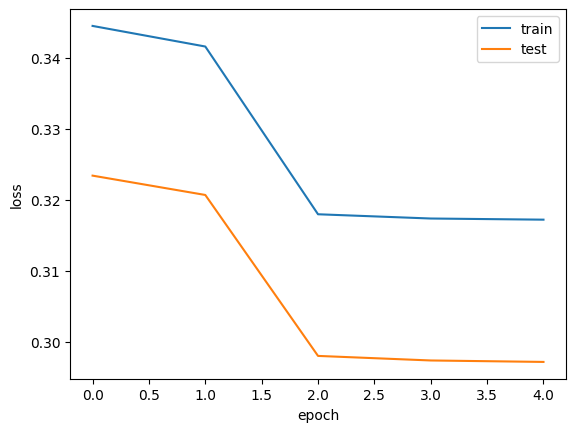

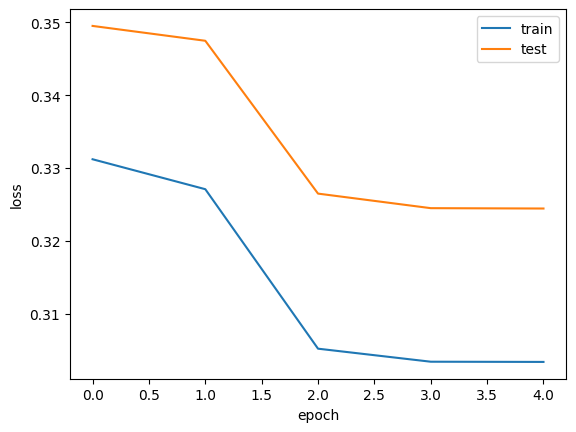

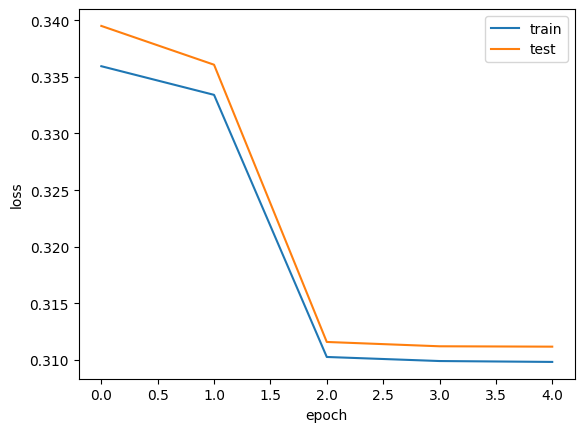

In [5]:
lr: float = 4e-2
n_epoch: int = 3
n_splits: int = 3
batch_size: int = 512
verbose: bool = True

dataset = pd.read_csv("./revlog_history.tsv", sep='\t', index_col=None, dtype={'r_history': str ,'t_history': str} )
dataset = dataset[(dataset['i'] > 1) & (dataset['delta_t'] > 0) & (dataset['t_history'].str.count(',0') == 0)]
if dataset.empty:
    raise ValueError('Training data is inadequate.')
dataset['tensor'] = dataset.progress_apply(lambda x: lineToTensor(list(zip([x['t_history']], [x['r_history']]))[0]), axis=1)
dataset['group'] = dataset['r_history'] + dataset['t_history']
print("Tensorized!")

n_pre_train_groups = len(dataset[dataset['i'] == 2]['group'].unique())
if n_pre_train_groups < n_splits:
    print("Not enough groups for pre-training. Splitting into {} folds.".format(n_pre_train_groups))
    n_splits = n_pre_train_groups

w = []
plots = []
if n_splits > 1:
    sgkf = StratifiedGroupKFold(n_splits=n_splits)
    for train_index, test_index in sgkf.split(dataset, dataset['i'], dataset['group']):
        print("TRAIN:", len(train_index), "TEST:",  len(test_index))
        train_set = dataset.iloc[train_index].copy()
        test_set = dataset.iloc[test_index].copy()
        trainer = Trainer(train_set, test_set, init_w, n_epoch=n_epoch, lr=lr, batch_size=batch_size)
        w.append(trainer.train(verbose=verbose))
        plots.append(trainer.plot())
else:
    trainer = Trainer(dataset, dataset, init_w, n_epoch=n_epoch, lr=lr, batch_size=batch_size)
    w.append(trainer.train(verbose=verbose))
    plots.append(trainer.plot())

w = np.array(w)
avg_w = np.round(np.mean(w, axis=0), 4)
w = avg_w.tolist()
print("\nTraining finished!")

In [6]:
print(w)

class Collection:
    def __init__(self, w: List[float]) -> None:
        self.model = FSRS(w)
        self.model.eval()

    def predict(self, t_history: str, r_history: str):
        with torch.no_grad():
            line_tensor = lineToTensor(list(zip([t_history], [r_history]))[0]).unsqueeze(1)
            output_t = self.model(line_tensor)
            return output_t[-1][0]

    def batch_predict(self, dataset):
        fast_dataset = RevlogDataset(dataset)
        with torch.no_grad():
            outputs, _ = self.model(fast_dataset.x_train.transpose(0, 1))
            stabilities, difficulties = outputs[fast_dataset.seq_len-1, torch.arange(len(fast_dataset))].transpose(0, 1)
            return stabilities.tolist(), difficulties.tolist()
        
requestRetention = 0.9

my_collection = Collection(w)
preview_text = "1:again, 2:hard, 3:good, 4:easy\n"
for first_rating in (1,2,3,4):
    preview_text += f'\nfirst rating: {first_rating}\n'
    t_history = "0"
    d_history = "0"
    r_history = f"{first_rating}"  # the first rating of the new card
    # print("stability, difficulty, lapses")
    for i in range(10):
        states = my_collection.predict(t_history, r_history)
        # print('{0:9.2f} {1:11.2f} {2:7.0f}'.format(
            # *list(map(lambda x: round(float(x), 4), states))))
        next_t = max(round(float(np.log(requestRetention)/np.log(0.9) * states[0])), 1)
        difficulty = round(float(states[1]), 1)
        t_history += f',{int(next_t)}'
        d_history += f',{difficulty}'
        r_history += f",3"
    preview_text += f"rating history: {r_history}\n"
    preview_text += "interval history: " + ",".join([f"{ivl}d" if ivl < 30 else f"{ivl / 30:.1f}m" if ivl < 365 else f"{ivl / 365:.1f}y" for ivl in map(int, t_history.split(','))]) + "\n"
    preview_text += f"difficulty history: {d_history}\n"
print(preview_text)

[1.5175, 2.0482, 4.8785, -1.9606, -1.8261, 0.05, 1.4788, -0.2206, 0.9072, 2.4097, -0.0214, 0.3333, 0.9109]
1:again, 2:hard, 3:good, 4:easy

first rating: 1
rating history: 1,3,3,3,3,3,3,3,3,3,3
interval history: 0d,2d,3d,6d,10d,18d,1.0m,1.6m,2.6m,4.1m,6.2m
difficulty history: 0,8.8,8.6,8.4,8.2,8.1,7.9,7.8,7.6,7.5,7.3

first rating: 2
rating history: 2,3,3,3,3,3,3,3,3,3,3
interval history: 0d,4d,9d,19d,1.2m,2.3m,4.0m,6.8m,10.9m,1.4y,2.1y
difficulty history: 0,6.8,6.7,6.6,6.6,6.5,6.4,6.3,6.2,6.2,6.1

first rating: 3
rating history: 3,3,3,3,3,3,3,3,3,3,3
interval history: 0d,6d,16d,1.3m,2.7m,5.4m,9.8m,1.4y,2.3y,3.6y,5.5y
difficulty history: 0,4.9,4.9,4.9,4.9,4.9,4.9,4.9,4.9,4.9,4.9

first rating: 4
rating history: 4,3,3,3,3,3,3,3,3,3,3
interval history: 0d,8d,25d,2.2m,5.0m,10.3m,1.6y,2.8y,4.8y,7.6y,11.6y
difficulty history: 0,2.9,3.0,3.1,3.2,3.3,3.4,3.4,3.5,3.6,3.6



In [7]:
test_rating_sequence = "3,3,3,3,3,1,1,3,3,3,3,3"
requestRetention = 0.9  # recommended setting: 0.8 ~ 0.9
easyBonus = 1.3
hardInterval = 1.2

t_history = "0"
d_history = "0"
for i in range(len(test_rating_sequence.split(','))):
    rating = test_rating_sequence[2*i]
    last_t = int(t_history.split(',')[-1])
    r_history = test_rating_sequence[:2*i+1]
    states = my_collection.predict(t_history, r_history)
    print(states)
    next_t = max(1,round(float(np.log(requestRetention)/np.log(0.9) * states[0])))
    if rating == '4':
        next_t = round(next_t * easyBonus)
    elif rating == '2':
        next_t = round(last_t * hardInterval)
    t_history += f',{int(next_t)}'
    difficulty = round(float(states[1]), 1)
    d_history += f',{difficulty}'
preview_text = f"rating history: {test_rating_sequence}\n"
preview_text += f"interval history: {t_history}\n"
preview_text += f"difficulty history: {d_history}"
print(preview_text)

tensor([5.6139, 4.8785])
tensor([16.0674,  4.8785])
tensor([38.1855,  4.8785])
tensor([81.5843,  4.8785])
tensor([160.7870,   4.8785])
tensor([11.2207,  8.3481])
tensor([ 3.2688, 10.0000])
tensor([4.4787, 9.7439])
tensor([6.2754, 9.5007])
tensor([9.1613, 9.2695])
tensor([13.6479,  9.0500])
tensor([20.7208,  8.8414])
rating history: 3,3,3,3,3,1,1,3,3,3,3,3
interval history: 0,6,16,38,82,161,11,3,4,6,9,14,21
difficulty history: 0,4.9,4.9,4.9,4.9,4.9,8.3,10.0,9.7,9.5,9.3,9.0,8.8


In [8]:
my_collection = Collection(init_w)
stabilities, difficulties = my_collection.batch_predict(dataset)
dataset['stability'] = stabilities
dataset['difficulty'] = difficulties
dataset['p'] = np.exp(np.log(0.9) * dataset['delta_t'] / dataset['stability'])
dataset['log_loss'] = dataset.apply(lambda row: - np.log(row['p']) if row['y'] == 1 else - np.log(1 - row['p']), axis=1)
loss_before = dataset['log_loss'].mean()

my_collection = Collection(w)
stabilities, difficulties = my_collection.batch_predict(dataset)
dataset['stability'] = stabilities
dataset['difficulty'] = difficulties
dataset['p'] = np.exp(np.log(0.9) * dataset['delta_t'] / dataset['stability'])
dataset['log_loss'] = dataset.apply(lambda row: - np.log(row['p']) if row['y'] == 1 else - np.log(1 - row['p']), axis=1)
loss_after = dataset['log_loss'].mean()

tmp = dataset.copy()
tmp['stability'] = tmp['stability'].map(lambda x: round(x, 2))
tmp['difficulty'] = tmp['difficulty'].map(lambda x: round(x, 2))
tmp['p'] = tmp['p'].map(lambda x: round(x, 2))
tmp['log_loss'] = tmp['log_loss'].map(lambda x: round(x, 2))
tmp.rename(columns={"r": "grade", "p": "retrievability"}, inplace=True)
tmp[['id', 'cid', 'review_date', 'r_history', 't_history', 'delta_t', 'grade', 'stability', 'difficulty', 'retrievability', 'log_loss']].to_csv("./evaluation.tsv", sep='\t', index=False)
del tmp
print(f"loss before: {loss_before:.4f}, loss after: {loss_after:.4f}, improvement: {loss_before - loss_after:.4f}")

loss before: 0.3371, loss after: 0.3101, improvement: 0.0270


R-squared: 0.9342
RMSE: 0.0180
[0.10123924 0.88748061]


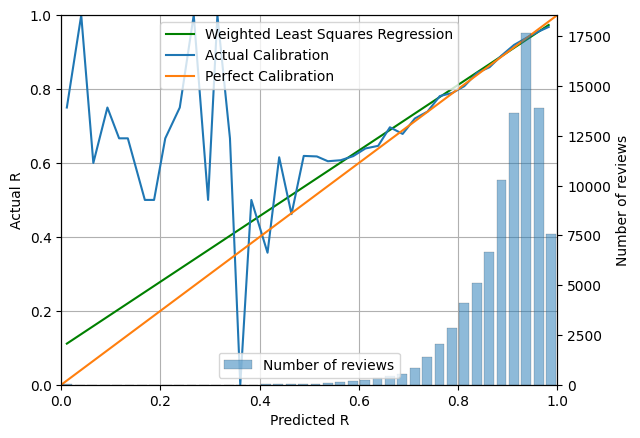


Last rating: 1
R-squared: 0.0997
RMSE: 0.0503
[0.35905057 0.57998195]

Last rating: 2
R-squared: -0.6784
RMSE: 0.0953
[-0.55756963  1.50702818]

Last rating: 3
R-squared: 0.9303
RMSE: 0.0205
[0.04162002 0.96619094]

Last rating: 4
R-squared: -0.3844
RMSE: 0.0360
[0.48503482 0.5067021 ]


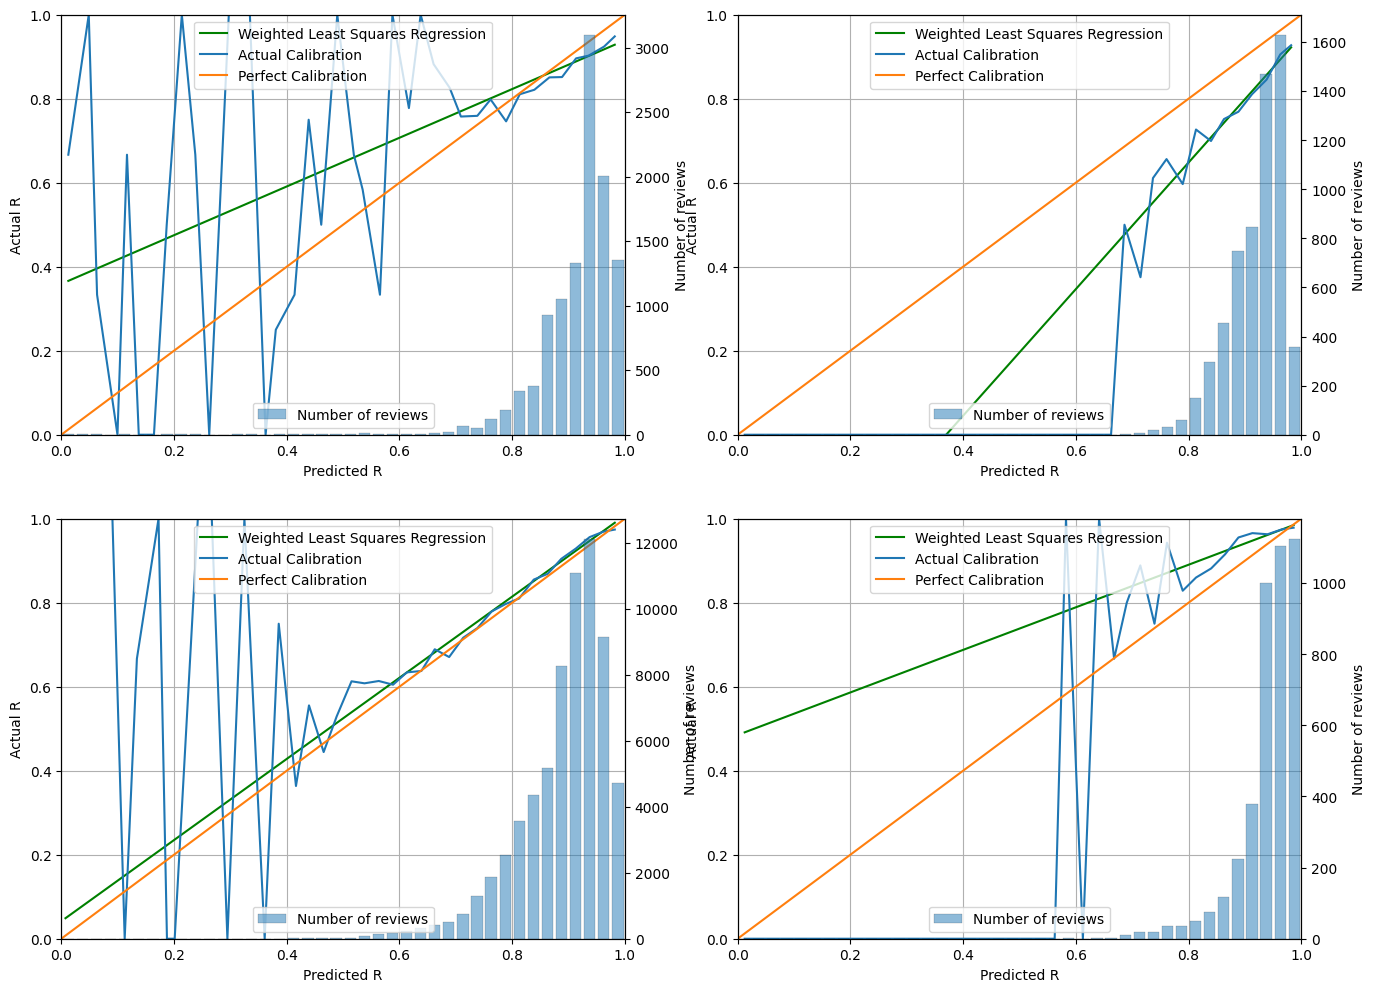

In [9]:
# code from https://github.com/papousek/duolingo-halflife-regression/blob/master/evaluation.py
def load_brier(predictions, real, bins=20):
    counts = np.zeros(bins)
    correct = np.zeros(bins)
    prediction = np.zeros(bins)
    for p, r in zip(predictions, real):
        bin = min(int(p * bins), bins - 1)
        counts[bin] += 1
        correct[bin] += r
        prediction[bin] += p
    np.seterr(invalid='ignore')
    prediction_means = prediction / counts
    prediction_means[np.isnan(prediction_means)] = ((np.arange(bins) + 0.5) / bins)[np.isnan(prediction_means)]
    correct_means = correct / counts
    correct_means[np.isnan(correct_means)] = 0
    size = len(predictions)
    answer_mean = sum(correct) / size
    return {
        "reliability": sum(counts * (correct_means - prediction_means) ** 2) / size,
        "resolution": sum(counts * (correct_means - answer_mean) ** 2) / size,
        "uncertainty": answer_mean * (1 - answer_mean),
        "detail": {
            "bin_count": bins,
            "bin_counts": list(counts),
            "bin_prediction_means": list(prediction_means),
            "bin_correct_means": list(correct_means),
        }
    }


def plot_brier(predictions, real, bins=20):
    brier = load_brier(predictions, real, bins=bins)
    bin_prediction_means = brier['detail']['bin_prediction_means']
    bin_correct_means = brier['detail']['bin_correct_means']
    bin_counts = brier['detail']['bin_counts']
    r2 = r2_score(bin_correct_means, bin_prediction_means, sample_weight=bin_counts)
    rmse = mean_squared_error(bin_correct_means, bin_prediction_means, sample_weight=bin_counts, squared=False)
    print(f"R-squared: {r2:.4f}")
    print(f"RMSE: {rmse:.4f}")
    ax = plt.gca()
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    plt.grid(True)
    fit_wls = sm.WLS(bin_correct_means, sm.add_constant(bin_prediction_means), weights=bin_counts).fit()
    print(fit_wls.params)
    y_regression = [fit_wls.params[0] + fit_wls.params[1]*x for x in bin_prediction_means]
    plt.plot(bin_prediction_means, y_regression, label='Weighted Least Squares Regression', color="green")
    plt.plot(bin_prediction_means, bin_correct_means, label='Actual Calibration', color="#1f77b4")
    plt.plot((0, 1), (0, 1), label='Perfect Calibration', color="#ff7f0e")
    bin_count = brier['detail']['bin_count']
    counts = np.array(bin_counts)
    bins = (np.arange(bin_count) + 0.5) / bin_count
    plt.legend(loc='upper center')
    plt.xlabel('Predicted R')
    plt.ylabel('Actual R')
    plt.twinx()
    plt.ylabel('Number of reviews')
    plt.bar(bins, counts, width=(0.8 / bin_count), ec='k', lw=.2, alpha=0.5, label='Number of reviews')
    plt.legend(loc='lower center')


plot_brier(dataset['p'], dataset['y'], bins=40)
plt.show()
plt.figure(figsize=(16, 12))
for last_rating in ("1","2","3","4"):
    plt.subplot(2, 2, int(last_rating))
    print(f"\nLast rating: {last_rating}")
    plot_brier(dataset[dataset['r_history'].str.endswith(last_rating)]['p'], dataset[dataset['r_history'].str.endswith(last_rating)]['y'], bins=40)

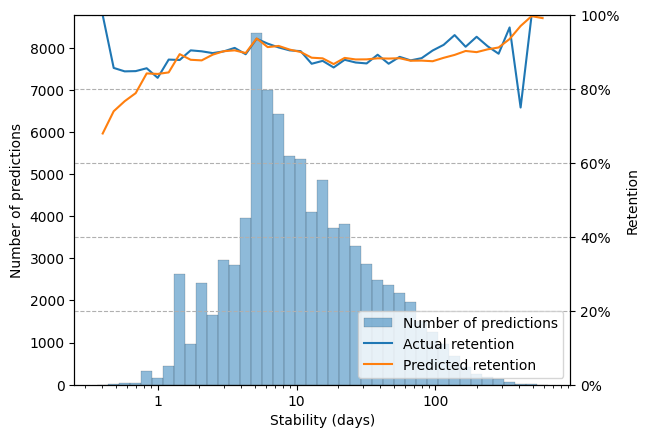

In [10]:
def to_percent(temp, position):
    return '%1.0f' % (100 * temp) + '%'

fig = plt.figure(1)
ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()
lns = []

stability_calibration = pd.DataFrame(columns=['stability', 'predicted_retention', 'actual_retention'])
stability_calibration = dataset[['stability', 'p', 'y']].copy()
stability_calibration['bin'] = stability_calibration['stability'].map(lambda x: math.pow(1.2, math.floor(math.log(x, 1.2))))
stability_group = stability_calibration.groupby('bin').count()

lns1 = ax1.bar(x=stability_group.index, height=stability_group['y'], width=stability_group.index / 5.5,
                ec='k', lw=.2, label='Number of predictions', alpha=0.5)
ax1.set_ylabel("Number of predictions")
ax1.set_xlabel("Stability (days)")
ax1.semilogx()
lns.append(lns1)

stability_group = stability_calibration.groupby(by='bin').agg('mean')
lns2 = ax2.plot(stability_group['y'], label='Actual retention')
lns3 = ax2.plot(stability_group['p'], label='Predicted retention')
ax2.set_ylabel("Retention")
ax2.set_ylim(0, 1)
lns.append(lns2[0])
lns.append(lns3[0])

labs = [l.get_label() for l in lns]
ax2.legend(lns, labs, loc='lower right')
plt.grid(linestyle='--')
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(to_percent))
plt.gca().xaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))
plt.show()

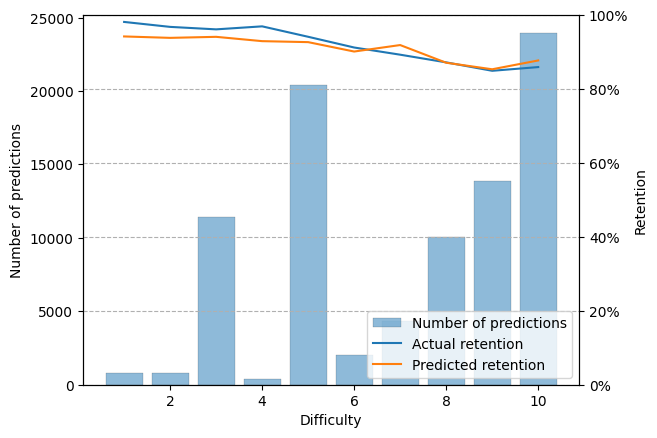

In [11]:
fig = plt.figure(1)
ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()
lns = []

difficulty_calibration = pd.DataFrame(columns=['difficulty', 'predicted_retention', 'actual_retention'])
difficulty_calibration = dataset[['difficulty', 'p', 'y']].copy()
difficulty_calibration['bin'] = difficulty_calibration['difficulty'].map(round)
difficulty_group = difficulty_calibration.groupby('bin').count()

lns1 = ax1.bar(x=difficulty_group.index, height=difficulty_group['y'],
                ec='k', lw=.2, label='Number of predictions', alpha=0.5)
ax1.set_ylabel("Number of predictions")
ax1.set_xlabel("Difficulty")
lns.append(lns1)

difficulty_group = difficulty_calibration.groupby(by='bin').agg('mean')
lns2 = ax2.plot(difficulty_group['y'], label='Actual retention')
lns3 = ax2.plot(difficulty_group['p'], label='Predicted retention')
ax2.set_ylabel("Retention")
ax2.set_ylim(0, 1)
lns.append(lns2[0])
lns.append(lns3[0])

labs = [l.get_label() for l in lns]
ax2.legend(lns, labs, loc='lower right')
plt.grid(linestyle='--')
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(to_percent))
plt.gca().xaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))
plt.show()

In [12]:
B_W_Metric_raw = dataset[['difficulty', 'stability', 'p', 'y']].copy()
B_W_Metric_raw['s_bin'] = B_W_Metric_raw['stability'].map(lambda x: round(math.pow(1.4, math.floor(math.log(x, 1.4))), 2))
B_W_Metric_raw['d_bin'] = B_W_Metric_raw['difficulty'].map(lambda x: int(round(x)))
B_W_Metric = B_W_Metric_raw.groupby(by=['s_bin', 'd_bin']).agg('mean').reset_index()
B_W_Metric_count = B_W_Metric_raw.groupby(by=['s_bin', 'd_bin']).agg('count').reset_index()
B_W_Metric['B-W'] = B_W_Metric['p'] - B_W_Metric['y']
n = len(dataset)
bins = len(B_W_Metric)
B_W_Metric_pivot = B_W_Metric[B_W_Metric_count['p'] > max(50, n / (3 * bins))].pivot(index="s_bin", columns='d_bin', values='B-W')
B_W_Metric_pivot.apply(pd.to_numeric).style.background_gradient(cmap='seismic', axis=None, vmin=-0.2, vmax=0.2).format("{:.2%}", na_rep='')

d_bin,3,5,6,7,8,9,10
s_bin,,,,,,,
0.710000,,,,,,,-2.04%
1.000000,,,,,,,-2.08%
1.400000,,,,,,2.59%,-2.30%
1.960000,,,,,1.34%,-4.67%,-0.80%
2.740000,,,,4.70%,-0.47%,0.55%,-0.76%
3.840000,,,,-0.58%,-2.10%,-5.36%,0.98%
5.380000,,-1.04%,,-1.03%,-2.18%,-1.97%,1.59%
7.530000,-1.41%,-1.46%,,-0.33%,0.63%,-1.42%,4.01%
10.540000,-1.50%,-2.15%,,3.80%,0.39%,1.36%,5.11%


R_Metric:  0.03967942303599237
R-squared: -6.8749
RMSE: 0.1527
[0.68927589 0.25115013]


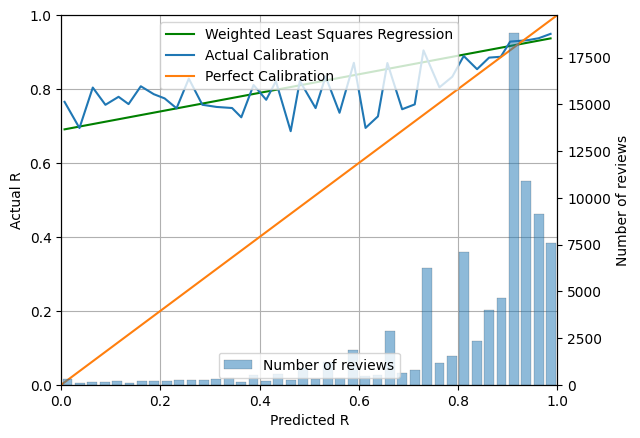

Universal Metric of FSRS: 0.0098
Universal Metric of SM2: 0.0801


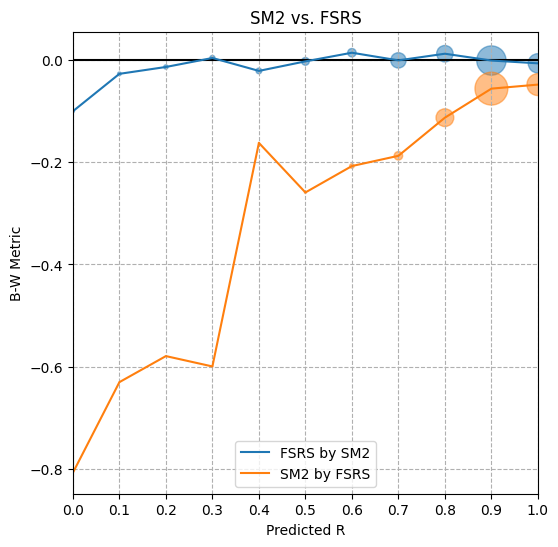

In [13]:
def sm2(history):
    ivl = 0
    ef = 2.5
    reps = 0
    for delta_t, rating in history:
        delta_t = delta_t.item()
        rating = rating.item() + 1
        if rating > 2:
            if reps == 0:
                ivl = 1
                reps = 1
            elif reps == 1:
                ivl = 6
                reps = 2
            else:
                ivl = ivl * ef
                reps += 1
        else:
            ivl = 1
            reps = 0
        ef = max(1.3, ef + (0.1 - (5 - rating) * (0.08 + (5 - rating) * 0.02)))
        ivl = max(1, round(ivl+0.01))
    return ivl

dataset['sm2_interval'] = dataset['tensor'].map(sm2)
dataset['sm2_p'] = np.exp(np.log(0.9) * dataset['delta_t'] / dataset['sm2_interval'])
cross_comparison = dataset[['sm2_p', 'p', 'y']].copy()

R_Metric = mean_squared_error(cross_comparison['y'], cross_comparison['sm2_p'], squared=False) - mean_squared_error(cross_comparison['y'], cross_comparison['p'], squared=False)
print("R_Metric: ", R_Metric)
plot_brier(dataset['sm2_p'], dataset['y'], bins=40)
plt.show()

plt.figure(figsize=(6, 6))

cross_comparison['SM2_B-W'] = cross_comparison['sm2_p'] - cross_comparison['y']
cross_comparison['SM2_bin'] = cross_comparison['sm2_p'].map(lambda x: round(x, 1))
cross_comparison['FSRS_B-W'] = cross_comparison['p'] - cross_comparison['y']
cross_comparison['FSRS_bin'] = cross_comparison['p'].map(lambda x: round(x, 1))

plt.axhline(y = 0.0, color = 'black', linestyle = '-')

cross_comparison_group = cross_comparison.groupby(by='SM2_bin').agg({'y': ['mean'], 'FSRS_B-W': ['mean'], 'p': ['mean', 'count']})
print(f"Universal Metric of FSRS: {mean_squared_error(cross_comparison_group['y', 'mean'], cross_comparison_group['p', 'mean'], sample_weight=cross_comparison_group['p', 'count'], squared=False):.4f}")
cross_comparison_group['p', 'percent'] = cross_comparison_group['p', 'count'] / cross_comparison_group['p', 'count'].sum()
plt.scatter(cross_comparison_group.index, cross_comparison_group['FSRS_B-W', 'mean'], s=cross_comparison_group['p', 'percent'] * 1024, alpha=0.5)
plt.plot(cross_comparison_group['FSRS_B-W', 'mean'], label='FSRS by SM2')

cross_comparison_group = cross_comparison.groupby(by='FSRS_bin').agg({'y': ['mean'], 'SM2_B-W': ['mean'], 'sm2_p': ['mean', 'count']})
print(f"Universal Metric of SM2: {mean_squared_error(cross_comparison_group['y', 'mean'], cross_comparison_group['sm2_p', 'mean'], sample_weight=cross_comparison_group['sm2_p', 'count'], squared=False):.4f}")
cross_comparison_group['sm2_p', 'percent'] = cross_comparison_group['sm2_p', 'count'] / cross_comparison_group['sm2_p', 'count'].sum()
plt.scatter(cross_comparison_group.index, cross_comparison_group['SM2_B-W', 'mean'], s=cross_comparison_group['sm2_p', 'percent'] * 1024, alpha=0.5)
plt.plot(cross_comparison_group['SM2_B-W', 'mean'], label='SM2 by FSRS')

plt.legend(loc='lower center')
plt.grid(linestyle='--')
plt.title("SM2 vs. FSRS")
plt.xlabel('Predicted R')
plt.ylabel('B-W Metric')
plt.xlim(0, 1)
plt.xticks(np.arange(0, 1.1, 0.1))
plt.show()